# Load Data

In [26]:
import numpy as np
import json
import csv

k = 3
X = np.genfromtxt('../data/softkmeans_logloss_X%d.csv' % k, delimiter=',', skip_header=True, usecols=range(1, k+1)).T
Y = np.genfromtxt('../data/softkmeans_logloss_Y%d.csv' % k, delimiter=',', skip_header=True)

data = np.genfromtxt('../data/all_samples_filtered.csv', delimiter=',', skip_header=True, missing_values=['None', ''])
print(data)
data = data[:, 1:]
data[np.where(data == 0)] = -1
data[np.where(data > 0)] = 1
data[np.where(np.isnan(data))] = 0
print(data)
m, n = data.shape

with open('../data/all_samples_filtered_labels.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    key_to_index = dict([(h, i) for i, h in enumerate(header[1:])])
    data_labels = [x[1:] for x in reader]
    

with open('../data/all_samples_filtered.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    
def get_label(i, key):
    return data_labels[i][key_to_index[key]]
        
print(get_label(0, 'ADIR:diagnosis'))
print(X.shape, Y.shape)

[[ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 ..., 
 [ nan   0.  nan ...,   0.   0.   0.]
 [ nan   0.  nan ...,   0.   0.   0.]
 [ nan   0.  nan ...,   1.   0.   0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0. -1. ...,  0.  0.  0.]
 ..., 
 [-1.  0. -1. ..., -1. -1. -1.]
 [-1.  0. -1. ..., -1. -1. -1.]
 [-1.  0. -1. ...,  1. -1. -1.]]
Autism
(3, 13433) (3, 123)


//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]


In [27]:
# Pull age and gender
with open('../data/all_samples.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    gender, age = [], []
    for line in reader:
        gender.append(None if line[7] == 'None' or line[7] == '' else line[7])
        if line[15] != 'None' and line[15] != '':
            age.append(int(line[15]))
        elif line[328] != 'None' and line[328] != '':
            age.append(int(line[328]))
        else:
            age.append(None)
print(age[:10])

[120, 120, 120, 120, 161, 117, 142, 119, 58, 47]


# Understand our validation data
Our validation data comes from ADIR and ADOS. Both give a diagnosis, and both also break down that diagnosis into three categories: communication, social interaction, and restricted and repeptitive behavior. These are the diagnostic criteria for ASD. Let's take a look at how these scores are distributed across our dataset.

## Diagnosis
This pie chart shows the diagnosis distribution across our dataset. The first diagnosis is ADIR and the second is ADOS. They have only 81% concordance.

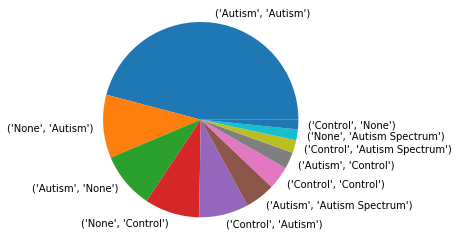

0.5466726217061189


In [23]:
from collections import Counter
import matplotlib.pyplot as plt


c = Counter([(get_label(i, 'ADIR:diagnosis'), get_label(i, 'ADOS:diagnosis')) for i in range(m)])
keys = [k for k, v in c.most_common()]
plt.pie([c[k] for k in keys], labels=keys)
plt.axis('equal')
plt.show()

print(sum([v for k, v in c.items() if (('Autism' in k[0] and 'Autism' in k[1]) or ('Control' in k[0] and 'Control' in k[1]))])/sum([v for v in c.values()]))


## Subscores - Communication, Social Interaction, and Restricted Repetitive Behavior
The communication scores are not correlated.

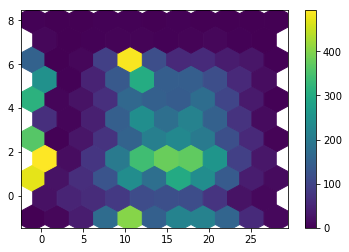

(-0.023213093331833932, 0.028415229048177858)


In [11]:
adir_com = [get_label(i, 'ADIR:communication') for i in range(m)]
ados_com = [get_label(i, 'ADOS:communication') for i in range(m)]

adir_com = [-1 if x == 'None' else int(x) for x in adir_com]
ados_com = [-1 if x == 'None' else int(x) for x in ados_com]

# remove double zeros
com = zip(adir_com, ados_com)
com = [(a, b) for a, b in com if a>0 or b>0]

# plot
cay = plt.hexbin([a for a, b in com], [b for a, b in com], gridsize=10)
plt.colorbar(cay)
plt.show()

# pearson r
from scipy.stats.stats import pearsonr
print(pearsonr(np.asarray([a for a, b in com if a != -1 and b != -1], float), np.asarray([b for a, b in com if a != -1 and b != -1], float)))

The social interaction scores are correlated - pearson r is 0.43

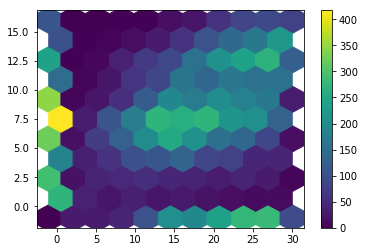

(0.43076994497652366, 0.0)


In [12]:
adir_si = [get_label(i, 'ADIR:social_interaction') for i in range(m)]
ados_si = [get_label(i, 'ADOS:social_interaction') for i in range(m)]

adir_si = [-1 if x == 'None' else int(x) for x in adir_si]
ados_si = [-1 if x == 'None' else int(x) for x in ados_si]

# remove double zeros
si = zip(adir_si, ados_si)
si = [(a, b) for a, b in si if a>0 or b>0]

# plot
cay = plt.hexbin([a for a, b in si], [b for a, b in si], gridsize=10)
plt.colorbar(cay)
plt.show()

# pearson r
print(pearsonr(np.asarray([a for a, b in si if a != -1 and b != -1], float), np.asarray([b for a, b in si if a != -1 and b != -1], float)))

The restricted, repetitive behavior scores are weakly correlated - pearson r is .11

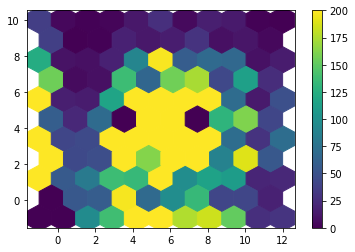

(0.11481944981684143, 2.3579564259200109e-27)


In [13]:
adir_rrb = [get_label(i, 'ADIR:restricted_repetitive_behavior') for i in range(m)]
ados_rrb = [get_label(i, 'ADOS:restricted_repetitive_behavior') for i in range(m)]

adir_rrb = [-1 if x == 'None' else int(x) for x in adir_rrb]
ados_rrb = [-1 if x == 'None' else int(x) for x in ados_rrb]

# remove double zeros
rrb = zip(adir_rrb, ados_rrb)
rrb = [(a, b) for a, b in rrb if a>0 or b>0]

# plot
cay = plt.hexbin([a for a, b in rrb], [b for a, b in rrb], gridsize=10, vmax=200)
plt.colorbar(cay)
plt.show()

# pearson r
print(pearsonr(np.asarray([a for a, b in rrb if a != -1 and b != -1], float), np.asarray([b for a, b in rrb if a != -1 and b != -1], float)))

In [24]:
print(np.sum(X, 1))

[           nan  4620.19879296  5129.35903331  3683.44217374]


In [15]:
from sklearn.cluster import KMeans
Z = np.genfromtxt('../data/impute_logloss_realfill_Z5.csv', delimiter=',', skip_header=True, missing_values=['None', ''])
Z = Z[:, 1:]
m, n = Z.shape
#autism_indices = [i for i in range(m) if 'Autism' not in get_label(i, 'ADIR:diagnosis') and 'Autism' not in get_label(i, 'ADOS:diagnosis')]
#Z[autism_indices, :] = 0

In [16]:
print(Z.shape)
print(len(adir_labels))
print(len(ados_labels))
k=4
clusters = KMeans(n_clusters=k).fit(Z)

(13434, 123)
3
4


[   13    14    23 ..., 13431 13432 13433]
[    0     1     2 ..., 13420 13421 13423]
[    6     7     8 ..., 13411 13415 13418]


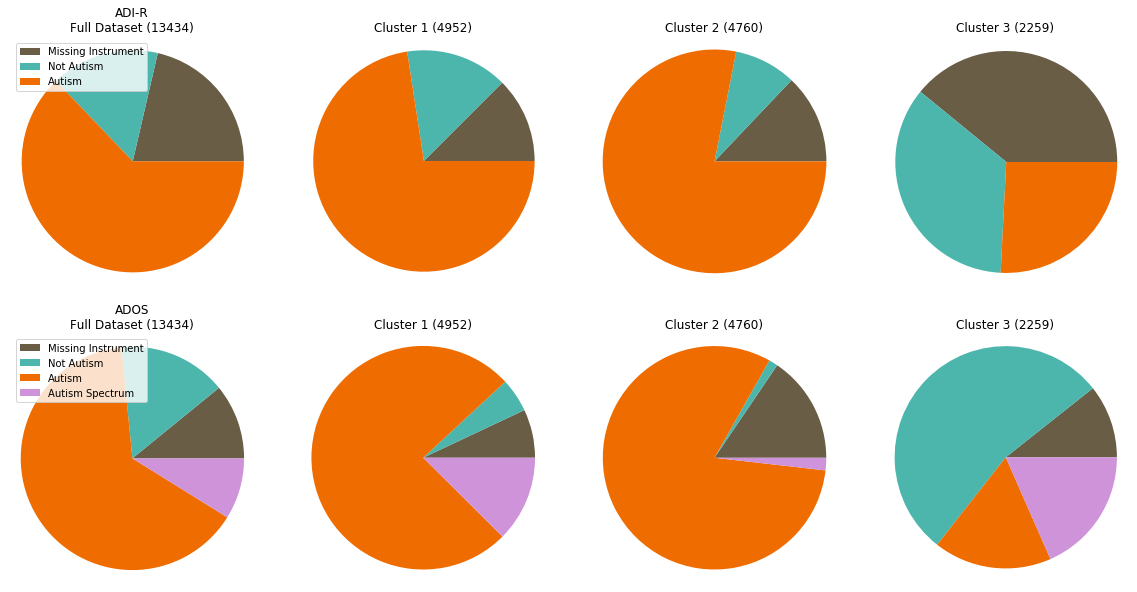

In [28]:
from collections import Counter
import math

plt.figure(figsize=(20, 10))


adir_c = Counter([get_label(index, 'ADIR:diagnosis') for index in range(m)])
ados_c = Counter([get_label(index, 'ADOS:diagnosis') for index in range(m)])

adir_keys = ["None", "Control", "Autism"]
ados_keys = ["None", "Control", "Autism", "Autism Spectrum"]

adir_labels = ["Missing Instrument", "Not Autism", "Autism", ]
ados_labels = ["Missing Instrument", "Not Autism", "Autism", "Autism Spectrum"]
colors = ["#695d46", "#4db6ac", "#ef6c00", "#ce93d8" ]
plt.subplot(2, k+1, 1)
plt.pie([adir_c[k] for k in adir_keys], colors=colors)
plt.title('ADI-R\nFull Dataset (%d)' % m)
plt.axis('equal')
plt.legend(loc="upper left", labels=adir_labels)

plt.subplot(2, k+1, k+2)
plt.pie([ados_c[k] for k in ados_keys], colors=colors)
plt.title('ADOS\nFull Dataset (%d)' % m)
plt.axis('equal')
plt.legend(loc="upper left", labels=ados_labels)
    
for i in range(k):
    #indexes = np.where(X[i, :]>.5)[0]
    #indexes = np.where(X[i, :]==np.amax(X, axis=0))[0]
    indexes = np.where(clusters.predict(Z)==i)[0]
    print(indexes)
    #indexes = np.where(X[i, :]> 0)[0]
    c = Counter([get_label(index, 'ADIR:diagnosis') for index in indexes])
    
    plt.subplot(2, k+1, i+2)
    plt.pie([c[k] for k in adir_keys], colors=colors)
    plt.title('Cluster %d (%d)' % (i+1, len(indexes)))
    plt.axis('equal')
    
    c = Counter([get_label(index, 'ADOS:diagnosis') for index in indexes])
    plt.subplot(2, k+1, i+k+3)
    plt.pie([c[k] for k in ados_keys], colors=colors)
    plt.title('Cluster %d (%d)' % (i+1, len(indexes)))
    plt.axis('equal')
    

plt.show()
    

            

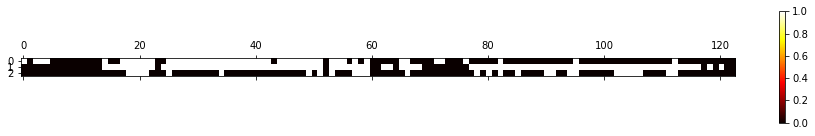

In [362]:
import matplotlib.pyplot as plt
cay = plt.matshow(Y>0, cmap='hot')
plt.colorbar(cay)
plt.show()

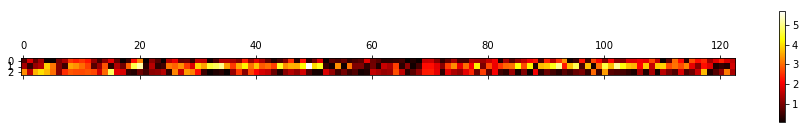

In [363]:
cay = plt.matshow(abs(Y), cmap='hot')
plt.colorbar(cay)
plt.show()

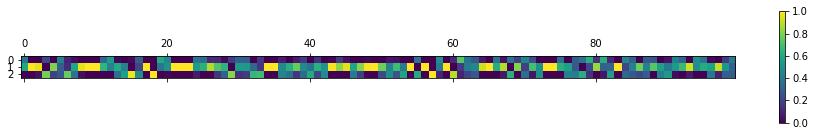

In [281]:
cay = plt.matshow(X[:, :100])
plt.colorbar(cay)
plt.show()

In [21]:
def missing_value_distance(a, b):
    return sum([c*d < 0 for c,d in zip(a, b) if not np.isnan(c) and not np.isnan(d)])

D = np.zeros((k, k))
for i in range(k):
    for j in range(k):
        if i < j:
            dist = missing_value_distance(Y[i, :], Y[j, :])
            D[i, j] = dist
            D[j, i] = dist
        elif i == j:
            indexes = np.where(X[i, :]> .4)[0]
            for x in indexes:
                D[i, i] += missing_value_distance(data[x, :], Y[i, :])
            D[i, i] = D[i, i]/len(indexes)
            
fig = plt.figure()
ax = fig.add_subplot(111)
cay = ax.matshow(D)
fig.colorbar(cay)

ax.set_xticklabels(['']+['Cluster %d'%(i+1) for i in range(k)])
ax.set_yticklabels(['']+['Cluster %d'%(i+1) for i in range(k)])
plt.show()

//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


IndexError: index 3 is out of bounds for axis 0 with size 3

In [18]:
key_indexes = np.asarray([keys.index((get_label(i, 'ADIR:diagnosis'), get_label(i, 'ADOS:diagnosis'))) for i in range(m)])

plt.figure(figsize=(18, 15))
j = 0
for i, key in enumerate(keys):
    if 'None' not in key[0] and 'None' not in key[1]:
        plt.subplot(4, 3, j+1)
        j += 1
        plt.axis((0,1,0,1))
        cay = plt.hexbin(X[0, key_indexes==i], X[1, key_indexes==i], gridsize=10)
        plt.colorbar(cay)
        plt.title('ADIR:%s, ADOS:%s, %d' % (key[0] if key[0] != 'Control' else 'Not Autism', key[1] if key[1] != 'Control' else 'Not Autism', all_c[key]))
plt.show()

//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 13433 but corresponding boolean dimension is 13434
  # Remove the CWD from sys.path while we load stuff.


NameError: name 'all_c' is not defined

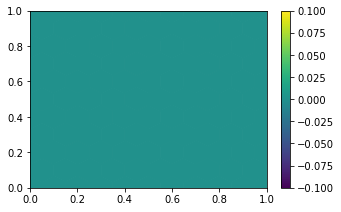

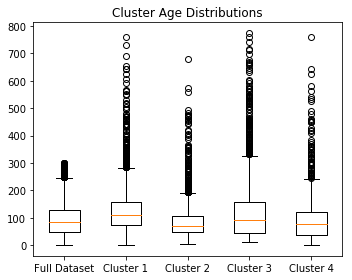

In [19]:
plt.figure(figsize=(5, 4))
age_boxplot_data = [[x for x in age if x is not None and x < 300]]
for i in range(k):
    plt.subplot(1, k+1, i+2)
    #indexes = [j for j in range(m) if age[j] is not None and age[j] < 300 and X[i, j] == np.max(X[:, j])]
    indexes = np.where(clusters.predict(Z)==i)[0]
    ages = [age[j] for j in indexes if age[j] is not None]
    #cay = plt.hexbin(X[i, indexes], ages, gridsize=10)
    #plt.colorbar(cay)
    #plt.title('Partial Cluster %d Membership vs Age' % (i+1))
    

    age_boxplot_data.append(ages)
    
plt.subplot(1, 1, 1)
#print([len(x) for x in boxplot_data])
plt.boxplot(age_boxplot_data, labels=["Full Dataset"] + ["Cluster %d" % (i+1) for i in range(k)])
plt.title('Cluster Age Distributions')
plt.tight_layout()
plt.show()

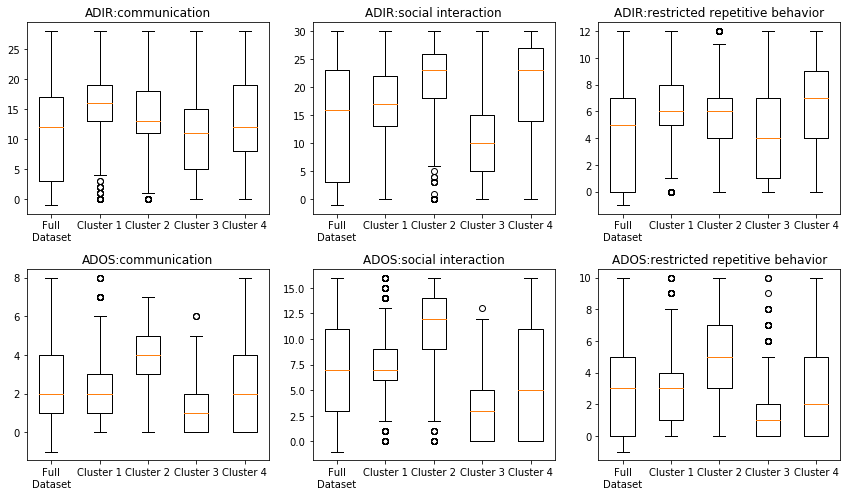

In [20]:
plt.figure(figsize=(12, 7))
for j, key in enumerate(['ADIR:communication', 'ADIR:social_interaction', 'ADIR:restricted_repetitive_behavior',
            'ADOS:communication', 'ADOS:social_interaction', 'ADOS:restricted_repetitive_behavior']):
    #print(key)
    scores = [get_label(i, key) for i in range(m)]
    scores = np.asarray([-1 if x == 'None' else int(x) for x in scores])
    
    boxplot_data = [scores]
    for i in range(k):
        #plt.subplot(1, k+1, i+2)
       # indexes = [j for j in range(m) if scores[j] is not None and X[i, j] == np.max(X[:, j])]
        indexes = np.where(clusters.predict(Z)==i)[0]
        #cay = plt.hexbin(X[i, indexes], scores[indexes], gridsize=10)
        #plt.colorbar(cay)
        #plt.title('Partial Cluster %d Membership vs \n%s Score' % (i+1, key))
        
        boxplot_data.append([scores[j] for j in indexes if scores[j]!= -1])
    
    plt.subplot(2, 3, j+1)
    #print([len(x) for x in boxplot_data])
    plt.boxplot(boxplot_data, labels=["Full\nDataset"] + ["Cluster %d" % (i+1) for i in range(k)])
    plt.title(key.replace('_', ' '))
plt.tight_layout()
plt.show()

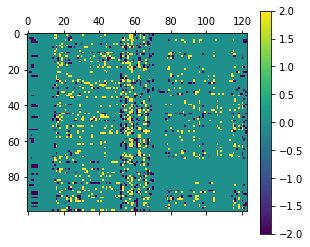

In [408]:
Z = X.T.dot(Y)
Z[np.where(Z > 0)] = 1
Z[np.where(Z <= 0)] = -1

error = np.zeros(Z.shape)
error[np.where(data != 0)] = Z[np.where(data != 0)]-data[np.where(data != 0)]
cay = plt.matshow(error[:100, :])
plt.colorbar(cay)
plt.show()

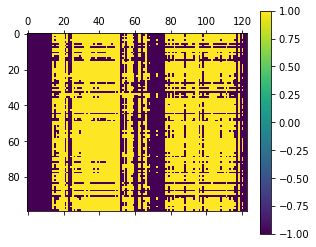

In [409]:
cay = plt.matshow(Z[:100, :])
plt.colorbar(cay)
plt.show()
Z[np.where(~np.isnan(data))] = data[np.where(~np.isnan(data))]

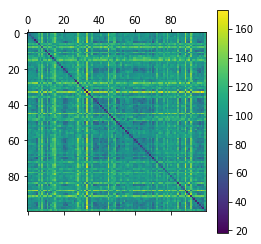

In [410]:
d = data.shape[1] - data.dot(data.T)

cay = plt.matshow(d[:100,:100])
plt.colorbar(cay)
plt.show()

In [412]:
ind = np.argsort(X.T, 1)[:, k-1]
avg_d_to_cluster = np.zeros((m, k))
for i in range(k):
    avg_d_to_cluster[:, i] = np.mean(d[:, ind==i], 1)

print(ind)
print(avg_d_to_cluster)

silhouette = (b-a)/np.maximum(a, b)
#plt.boxplot([silhouette[ind[:, 0] == 0], silhouette[ind[:, 0] == 1], silhouette[ind[:, 0] == 2]])
#plt.show()

print('Silhouette average', np.mean(silhouette))


[2 2 2 ..., 0 1 1]
[[ 121.08861859  110.68595297  104.96295748]
 [ 117.3391254   108.38428218  103.73418284]
 [ 114.37938025  101.45080446   99.81686176]
 ..., 
 [ 103.9646684    99.78805693  102.48288635]
 [ 101.79554011   87.15563119   95.86694325]
 [ 105.10541558   94.3230198    97.70854941]]
Silhouette average 0.248804268358


In [196]:
k = 3
X = np.loadtxt('../data/impute_logloss_X%d.csv' % k, delimiter=',').T
Y = np.loadtxt('../data/impute_logloss_Y%d.csv' % k, delimiter=',')
m = X.shape[0]
print(m)

FileNotFoundError: [Errno 2] No such file or directory: '../data/impute_logloss_X3.csv'

In [306]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=4)
model.fit(X)
print(model.labels_)

[1 2 2 ..., 3 0 3]


Automatically created module for IPython interactive environment
(13434, 123)
For n_clusters = 2 The average silhouette_score is : 0.376832520254


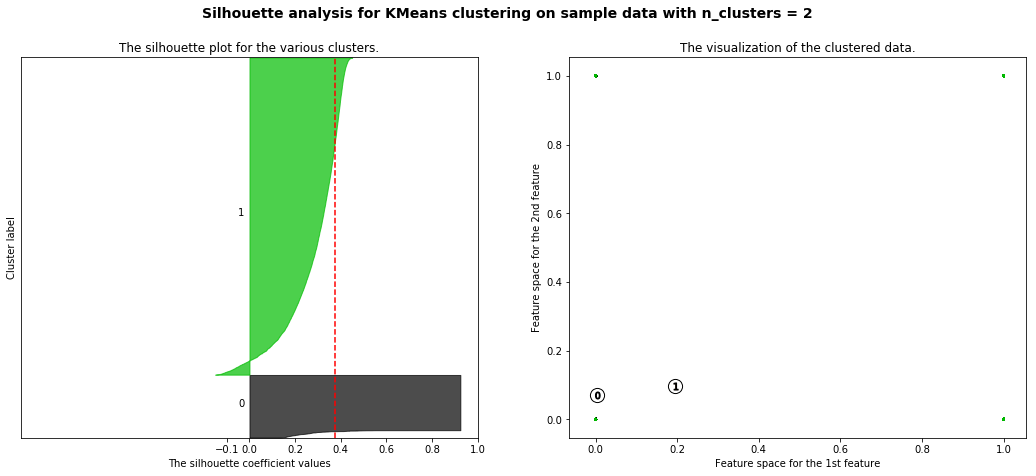

For n_clusters = 3 The average silhouette_score is : 0.231719659859


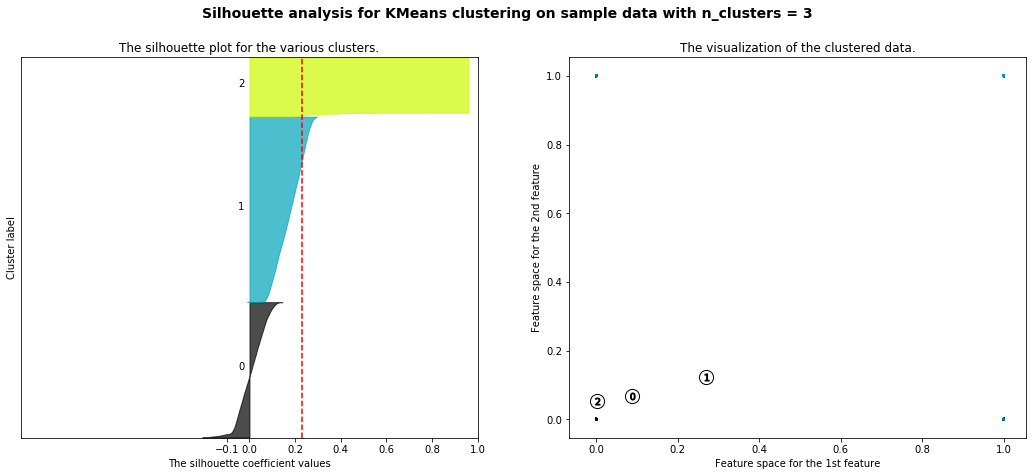

For n_clusters = 4 The average silhouette_score is : 0.201077898831


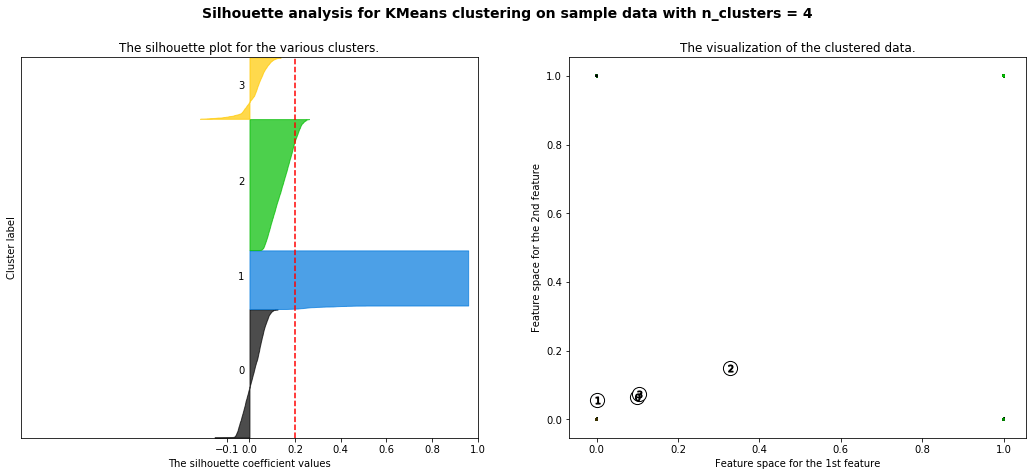

For n_clusters = 5 The average silhouette_score is : 0.191304260424


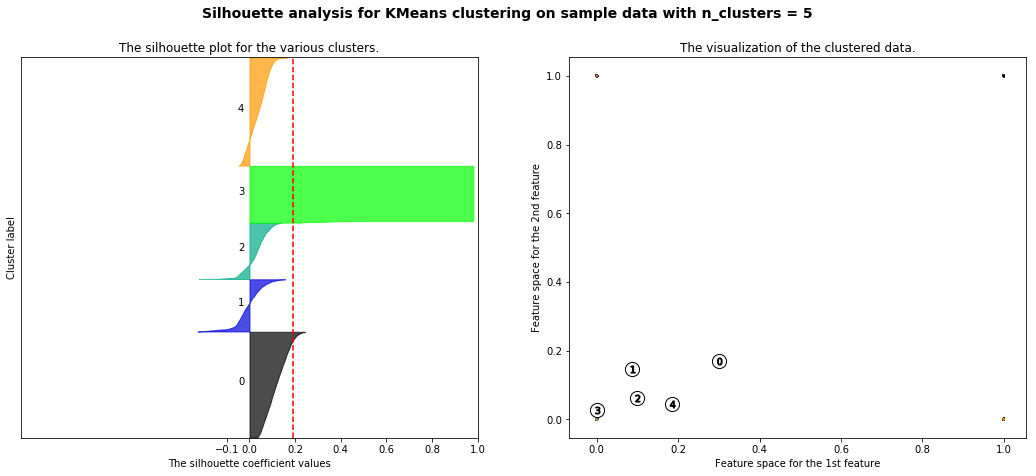

For n_clusters = 6 The average silhouette_score is : 0.186182313613


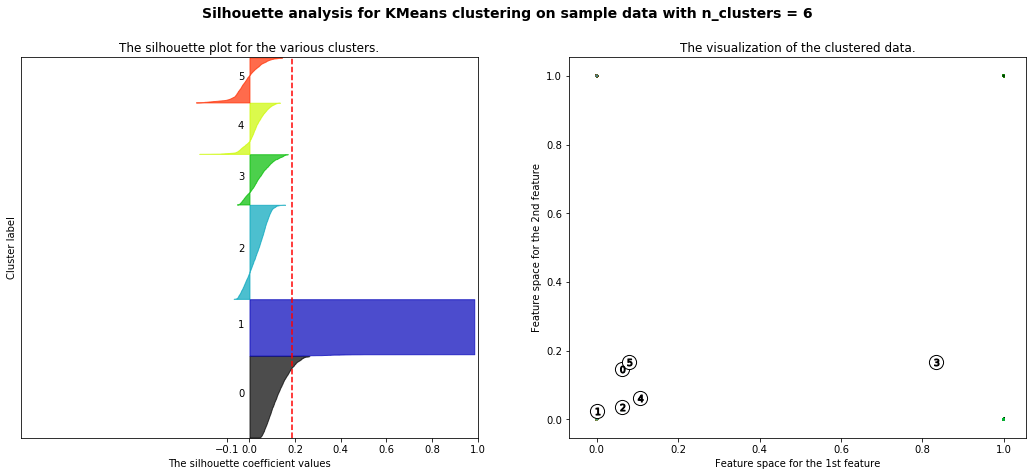

For n_clusters = 7 The average silhouette_score is : 0.183708595615


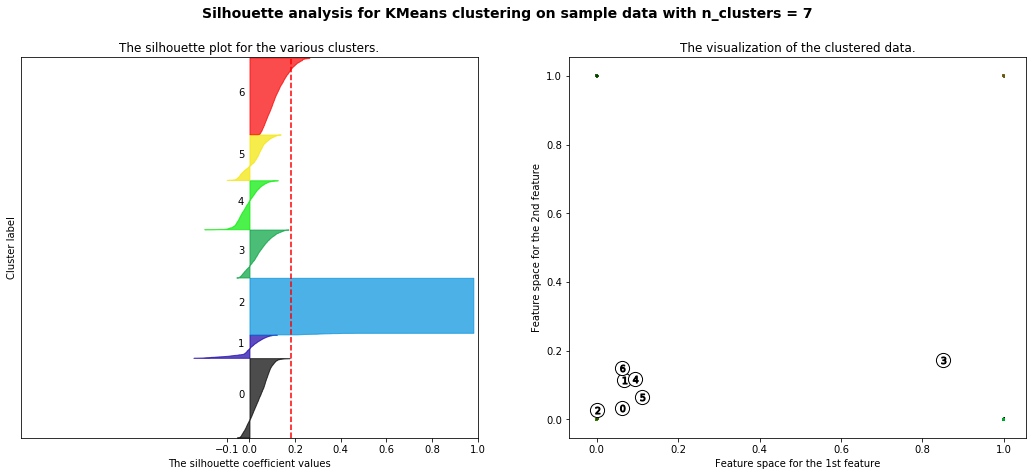

For n_clusters = 8 The average silhouette_score is : 0.186004666528


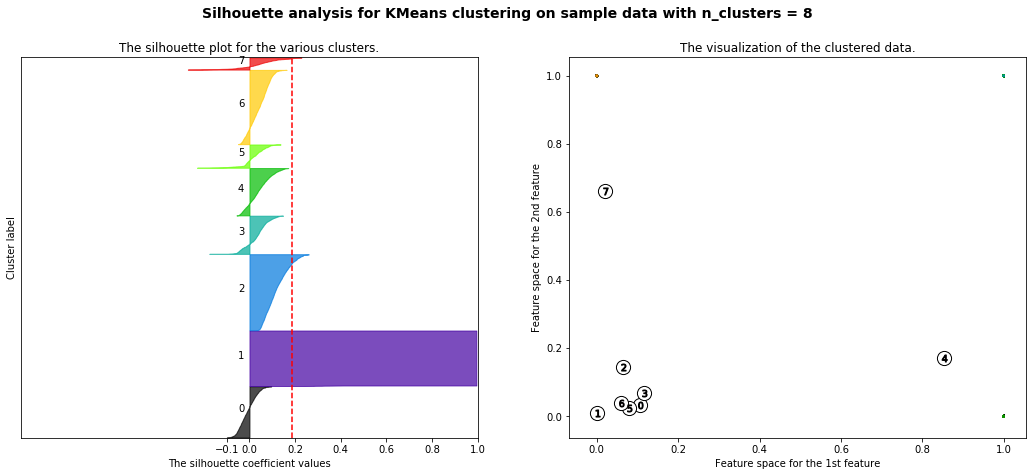

In [195]:
from __future__ import print_function

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import random

print(__doc__)

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
Z_subsample = Z
print(Z_subsample.shape)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(Z_subsample) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(Z_subsample)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(Z_subsample, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(Z_subsample, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(Z_subsample[:, 0], Z_subsample[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

dict_items([(('Autism', 'Autism'), 0), (('Control', 'Autism'), 1), (('Autism', 'Autism Spectrum'), 2), (('Control', 'Control'), 3), (('Autism', 'Control'), 4), (('Control', 'Autism Spectrum'), 5)])


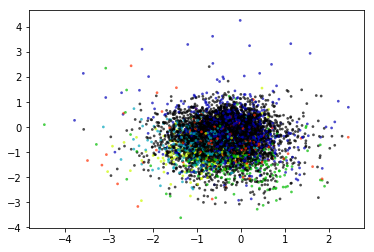

In [356]:
from collections import Counter
diag_to_index = dict([(k, i) for i, k in enumerate(keys)])
print(diag_to_index.items())
cluster_labels = np.asarray([diag_to_index[(get_label(i, 'ADIR:diagnosis'), get_label(i, 'ADOS:diagnosis'))] for i in range(m)])

colors = cm.spectral(cluster_labels.astype(float) / len(keys))
plt.scatter(X[:, 1], X[:, 2], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
#plt.scatter(X[cluster_labels == 0, 0], X[cluster_labels == 0, 1], marker='.', s=30, lw=0, alpha=0.7,
#                c="red", edgecolor='k')
plt.show()